## Action Plan
** Build model by LUNA to train Data Bowl 2017**

### LUNA
* **1. Data Preparation and Preprocessing **
* **2. Finetune and Train Model**
* **2b. Data Augmentation parameter tuning**
* **3. Generate and Validate Predictions**

### Data Bowl
* **1. Data Preparation and Preprocessing** 
* **2. Finetune and Train Model**
* **2b. Data Augmentation parameter tuning**
* **3. Generate and Validate Predictions** 
* **4. Submit predictions to Kaggle**

## Constructing a training set from the LUNA 2016 data


We are going to use the nodule locations as given in annotations.csv and extract three transverse slices that contain the largest nodule from each patient scan. Masks will be created for those slices based on the nodule dimensions given in annotations.csv. The output of this file will be two files for each patient scan: a set of images and a set of corresponding nodule masks. The data from the LUNA 2016 challenge can be found at https://luna16.grand-challenge.org/

First we import the necessary tools and find the largest nodule in the patient scan. There are multiple nodule listings for some patients in annotations.csv. We're using a pandas DataFrame named ```df_node``` to keep track of the case numbers and the node information. The node information is an (x,y,z) coordinate in mm using a coordinate system defined in the .mhd file. 

The following snippets of code are from [LUNA_mask_extraction.py](./tutorial_code/LUNA_mask_extraction.py):

In [1]:
import os
luna_path = "../input/LUNA16/"
luna_subset_path = "../input/LUNA16/subset0/"
output_path = "../input/LUNA16/output/"
if not os.path.exists(output_path): os.makedirs(output_path)

In [197]:
from importlib import reload
import dataprep_LUNA; reload(dataprep_LUNA)
from dataprep_LUNA import *
import utils_LUNA; reload(utils_LUNA)
from utils_LUNA import *

In [3]:
file_list=glob(luna_subset_path+"*.mhd")
print(len(file_list))

89


In [4]:
#
# The locations of the nodes
df_node = pd.read_csv(luna_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename, args=(file_list,))
df_node = df_node.dropna()

In [5]:
print(len(df_node))
df_node[:5]

112


,seriesuid,coordX,coordY,coordZ,diameter_mm,file
23,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.567944,67.260517,-231.816619,6.440879,../input/LUNA16/subset0/1.3.6.1.4.1.14519.5.2....
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,../input/LUNA16/subset0/1.3.6.1.4.1.14519.5.2....
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,../input/LUNA16/subset0/1.3.6.1.4.1.14519.5.2....
28,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.434059,117.765579,-181.947817,4.681382,../input/LUNA16/subset0/1.3.6.1.4.1.14519.5.2....
86,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,145.967465,-161.197634,-312.071347,6.378436,../input/LUNA16/subset0/1.3.6.1.4.1.14519.5.2....


## Getting the nodule position in the mhd files

The nodule locations are given in terms of millimeters relative to a coordinate system defined by the CT scanner. The image data is given as a varying length stack of 512 X 512 arrays. In order to translate the voxel position to the world coordinate system, one needs to know the real world position of the [0,0,0] voxel and the voxel spacing in mm. 

In [37]:
for fcount, img_file in enumerate(file_list):
    #print("Getting mask for image file %s" % img_file.replace(luna_subset_path,""))
    print("Getting mask for image file %s" % img_file.rsplit('/', 1)[-1].rsplit('\\', 1)[-1])
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if len(mini_df)>0:       # some files may not have a nodule--skipping those 
        get_images_and_masks(fcount, img_file, mini_df, output_path)
        get_images_and_masks_resample(fcount, img_file, mini_df, output_path)

Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd
Getting mask for image file 1.

Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668.mhd


Check to make sure the nodule masks look as expected:

image 0


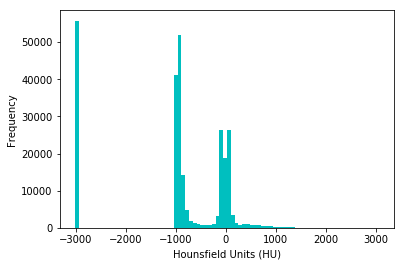

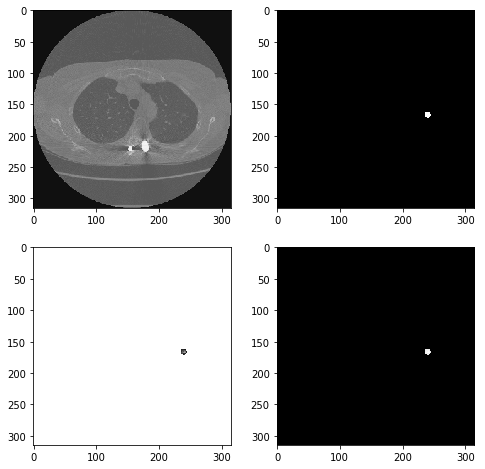

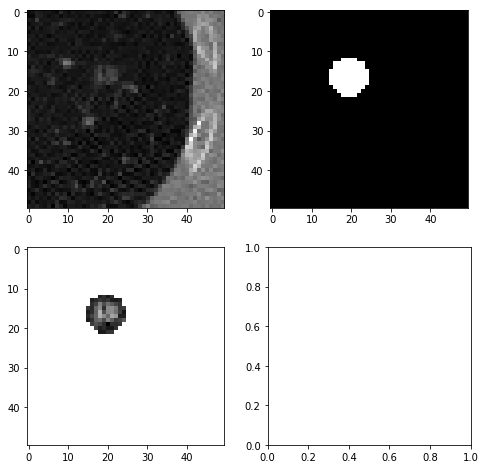

image 1


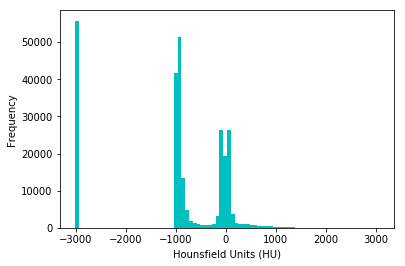

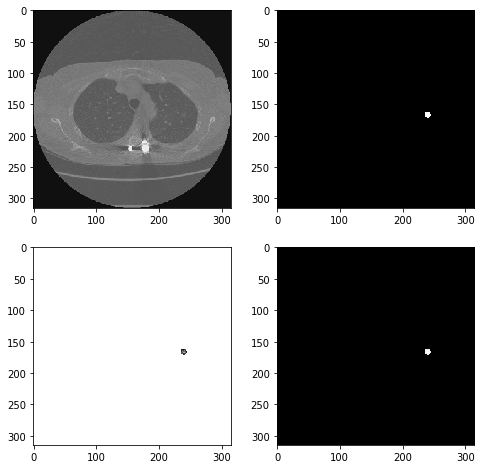

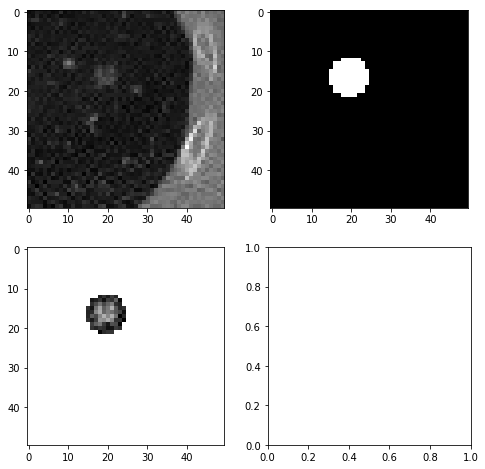

image 2


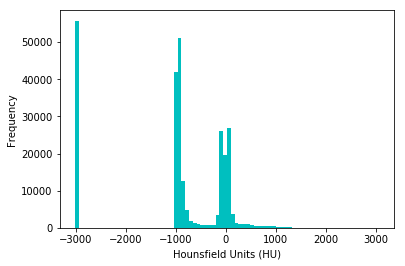

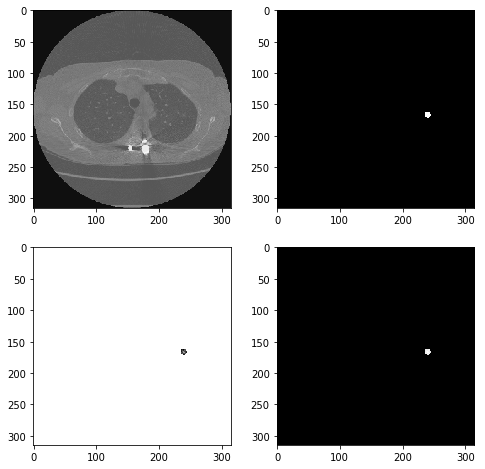

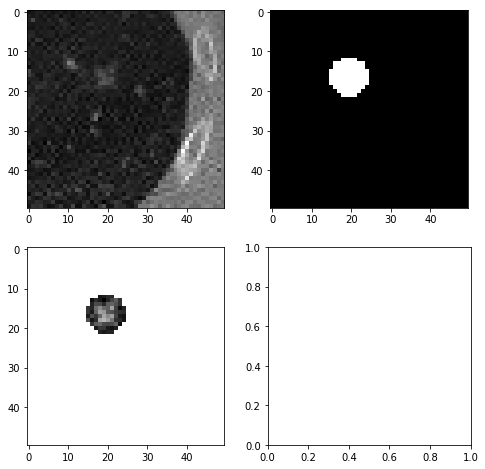

In [38]:
fcount, node_idx = (9, 117) # (8, 347) 
xzoom = slice(220, 270)
yzoom = slice(150, 200)
'''
imgs = np.load(output_path+'images_%04d_%04d.npy' % (fcount, node_idx))
masks = np.load(output_path+'masks_%04d_%04d.npy' % (fcount, node_idx))
spacing = np.load(output_path+'spacing_%04d_%04d.npy' % (fcount, node_idx))
'''
imgs_resampled = np.load(output_path+'images_resampled_%04d_%04d.npy' % (fcount, node_idx))
masks_resampled = np.load(output_path+'masks_resampled_%04d_%04d.npy' % (fcount, node_idx))
newspacing = np.load(output_path+'newspacing_%04d_%04d.npy' % (fcount, node_idx))

for i in range(len(imgs)):
    #print(newspacing)
    print("image %d" % i)
    plt.hist(imgs[i].flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs_resampled[i],cmap='gray')
    ax[0,1].imshow(masks_resampled[i],cmap='gray')
    ax[1,0].imshow(imgs_resampled[i]*masks_resampled[i],cmap='gray')
    ax[1,1].imshow((matrix2uint16(imgs_resampled[i])*masks_resampled[i]),cmap='gray')
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs_resampled[i][yzoom, xzoom],cmap='gray')
    ax[0,1].imshow(masks_resampled[i][yzoom, xzoom],cmap='gray')
    ax[1,0].imshow(imgs_resampled[i][yzoom, xzoom]*masks_resampled[i][yzoom, xzoom],cmap='gray')
    plt.show()

The image on the top left is the scan slice. The image on the top right is the node mask. The image on the bottom left is the masked slice, highlighting the node. 

![Example LUNA Mask](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/example_luna_mask.png)

Close up on the nodule : 

![Example LUNA Mask detail](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/example_luna_mask_detail.png)

## Isolation of the Lung Region of Interest to Narrow Our Nodule Search

The node masks seem to be constructed properly. The next step is to isolate the lungs in the images. We'll need
to import some skimage image processing modules for this step. The general strategy is to threshold the image to isolate the 
regions within the image, and then to identify which of those regions are the lungs. The lungs have a high constrast with the surrounding tissue, so the thresholding is fairly straightforward. We use some ad-hoc criteria for eliminating the non-lung regions from the image which do not apply equally to all data sets. 

In [192]:
file_list=glob(output_path+"images*.npy")
print(len(file_list))

224


In [195]:
file_list=glob(output_path+"images_resampled*.npy")
print(len(file_list))

112


In [198]:
for img_file in file_list:
    imgs_resampled = np.load(img_file)
    print("on image", img_file)
    segmented_lungs_fill = segment_lung_mask(imgs_resampled, True)
    np.save(img_file.replace("images_resampled","lungmask_resampled"), segmented_lungs_fill)

on image ../input/LUNA16/output/images_resampled_0039_0935.npy
on image ../input/LUNA16/output/images_resampled_0007_1049.npy
on image ../input/LUNA16/output/images_resampled_0044_0507.npy
on image ../input/LUNA16/output/images_resampled_0024_0132.npy
on image ../input/LUNA16/output/images_resampled_0045_0882.npy
on image ../input/LUNA16/output/images_resampled_0030_1106.npy
on image ../input/LUNA16/output/images_resampled_0042_0873.npy
on image ../input/LUNA16/output/images_resampled_0044_0506.npy
on image ../input/LUNA16/output/images_resampled_0049_0026.npy
on image ../input/LUNA16/output/images_resampled_0057_1012.npy
on image ../input/LUNA16/output/images_resampled_0080_0344.npy
on image ../input/LUNA16/output/images_resampled_0054_0621.npy
on image ../input/LUNA16/output/images_resampled_0003_1138.npy
on image ../input/LUNA16/output/images_resampled_0022_0783.npy
on image ../input/LUNA16/output/images_resampled_0078_0794.npy
on image ../input/LUNA16/output/images_resampled_0001_0

image 0


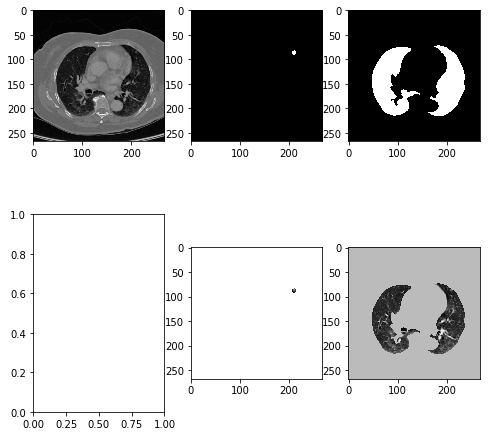

image 1


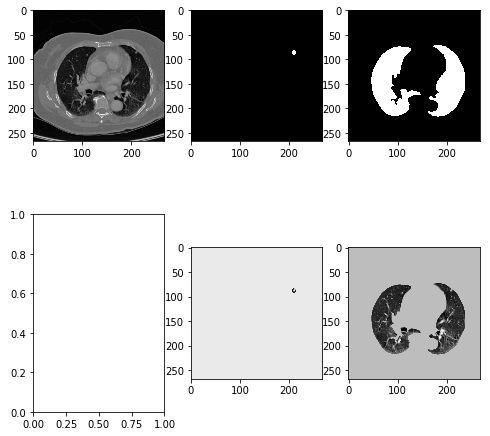

image 2


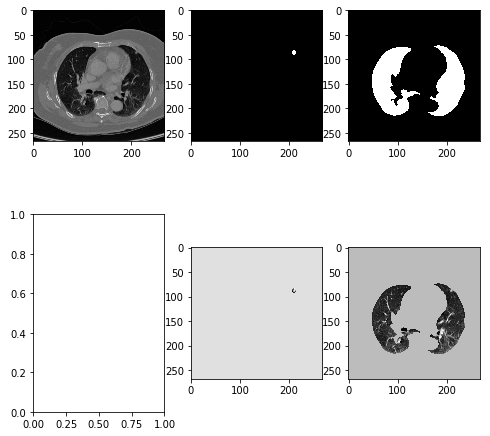

In [201]:
fcount, node_idx = (3, 1138) #(0, 1116), (1, 938), (3, 1138), (8, 347), (9, 117)
imgs_resampled = np.load(output_path+'images_resampled_%04d_%04d.npy' % (fcount, node_idx))
masks_resampled = np.load(output_path+'masks_resampled_%04d_%04d.npy' % (fcount, node_idx))
segmented_lungs_fill = np.load(output_path+'lungmask_resampled_%04d_%04d.npy' % (fcount, node_idx))
#segmented_lungs_fill = segment_lung_mask(imgs_resampled, True)

for i in range(len(imgs_resampled)):
    print("image %d" % i)
    fig,ax = plt.subplots(2,3,figsize=[8,8])
    ax[0,0].imshow(imgs_resampled[i],cmap='gray')
    ax[0,1].imshow(masks_resampled[i],cmap='gray')
    ax[0,2].imshow(segmented_lungs_fill[i],cmap='gray')
    ax[1,1].imshow(imgs_resampled[i]*masks_resampled[i],cmap='gray')
    ax[1,2].imshow(imgs_resampled[i]*segmented_lungs_fill[i],cmap='gray')
    plt.show()

### Erosion and Dilation

We then use an erosion and dilation to fill in the incursions into the lungs region by radio-opaque tissue, followed by a selection of the regions based on the bounding box sizes of each region. The initial set of regions looks like 

### Cutting non-ROI Regions
The cuts applied to each region bounding box were determined empirically and seem to work well for the LUNA data, but may not be generally applicable

In [89]:
for img_file in file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print("on image", img_file)
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        #Standardize the pixel values
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std
        # Find the average pixel value near the lungs
        # to renormalize washed out images
        middle = img[100:400,100:400] 
        mean = np.mean(middle)  
        max = np.max(img)
        min = np.min(img)
        # To improve threshold finding, I'm moving the 
        # underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean
        #
        # Using Kmeans to separate foreground (radio-opaque tissue)
        # and background (radio transparent tissue ie lungs)
        # Doing this only on the center of the image to avoid 
        # the non-tissue parts of the image as much as possible
        #
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
        #
        # I found an initial erosion helful for removing graininess from some of the regions
        # and then large dialation is used to make the lung region 
        # engulf the vessels and incursions into the lung cavity by 
        # radio opaque tissue
        #
        eroded = morphology.erosion(thresh_img,np.ones([4,4]))
        dilation = morphology.dilation(eroded,np.ones([10,10]))
        #
        #  Label each region and obtain the region properties
        #  The background region is removed by removing regions 
        #  with a bbox that is to large in either dimnsion
        #  Also, the lungs are generally far away from the top 
        #  and bottom of the image, so any regions that are too
        #  close to the top and bottom are removed
        #  This does not produce a perfect segmentation of the lungs
        #  from the image, but it is surprisingly good considering its
        #  simplicity. 
        #
        labels = measure.label(dilation)
        label_vals = np.unique(labels)
        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
                good_labels.append(prop.label)
        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        #
        #  The mask here is the mask for the lungs--not the nodes
        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask 
        #
        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
        imgs_to_process[i] = mask
    np.save(img_file.replace("images","lungmask"),imgs_to_process)

on image ../input/LUNA16/output/images_resampled_0039_0935.npy


ValueError: operands could not be broadcast together with shapes (512,512) (400,400) 

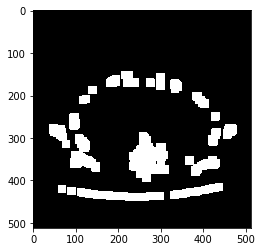

In [136]:
fcount, node_idx =  (9, 117) #(8, 347)

fname = output_path+"lungmask_%04d_%04d.npy" % (fcount, node_idx)
masks = np.load(fname)
plt.imshow(masks[1],cmap='gray')
plt.show()

![ROI Step 4](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/ROI_step4.png)

### Applying the ROI Masks

The next step in LUNA_segment_lung_ROI.py is applying the mask of the lung ROI to each of the images, cropping down to the bounding square of the lungs ROI, and then resizing the resulting image to 512 X 512. 

In [43]:
file_list=glob(output_path+"lungmask_*.npy")
len(file_list)

112

In [44]:
fcount, node_idx = (9, 117) # (8, 347)

#masks = np.load(output_path+"masks_%04d_%04d.npy" % (fcount, node_idx))
#imgs = np.load(output_path+"images_%04d_%04d.npy" % (fcount, node_idx))
#imgs = masks*imgs

fname = output_path+"lungmask_%04d_%04d.npy" % (fcount, node_idx)
imgs_to_process = np.load(fname.replace("lungmask","images"))
masks = np.load(fname)
node_masks = np.load(fname.replace("lungmask","masks"))

image 1


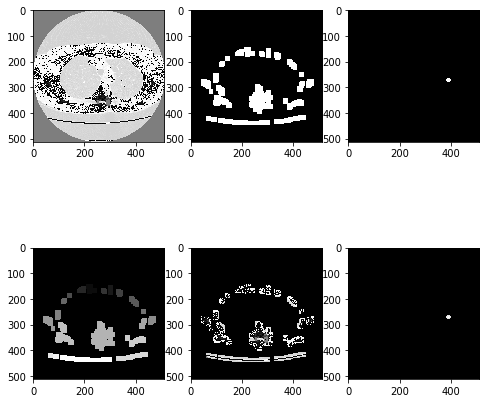

In [45]:
#for i in range(len(imgs)):
i = 1
print("image %d" % i)
fig,ax = plt.subplots(2,3,figsize=[8,8])
ax[0,0].imshow(imgs_to_process[i],cmap='gray')
ax[0,1].imshow(masks[i],cmap='gray')
ax[0,2].imshow(node_masks[i],cmap='gray')
ax[1,0].imshow(measure.label(masks[i]), cmap='gray')
ax[1,1].imshow(imgs_to_process[i]*masks[i],cmap='gray')
ax[1,2].imshow(imgs_to_process[i]*node_masks[i],cmap='gray')
plt.show()

#### Cropping
...crop to bounding square and resize to 512 X 512...

Then we perform some final pixel normalization. This is because the mask sends the non ROI area in the picture to 0, and that operation is not sensitive to the pixel value distribution. To fix this, we get the mean and standard deviation of the masked region and send the background (now zero) to the lower end of the pixel distribution (```-1.2*stdev```, which was chosen empirically). 

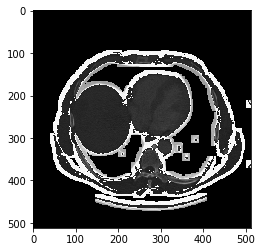

In [22]:
i = 1
mask = masks[i]
node_mask = node_masks[i]
img = imgs_to_process[i]
new_size = [512,512]   # we're scaling back up to the original size of the image
img= mask*img          # apply lung mask
#
# renormalizing the masked image (in the mask region)
#
new_mean = np.mean(img[mask>0])  
new_std = np.std(img[mask>0])
#
#  Pushing the background color up to the lower end
#  of the pixel range for the lungs
#
old_min = np.min(img)       # background color
img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
img = img-new_mean
img = img/new_std

#print(np.max(img), np.min(img))
plt.imshow(img, cmap='gray')
plt.show()

(94, 40, 442, 497)
(211, 501, 230, 512)
(294, 372, 313, 391)
(352, 501, 371, 512)
(429, 145, 471, 408)
94 471 40 512
472 377
94 566 40 512


/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


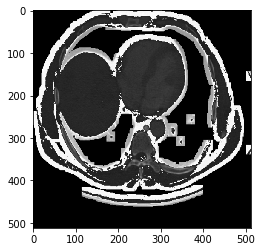

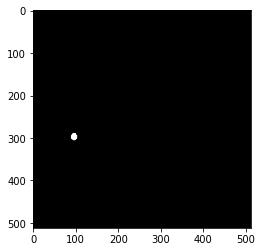

In [23]:
#make image bounding box  (min row, min col, max row, max col)
labels = measure.label(mask)
regions = measure.regionprops(labels)
#
# Finding the global min and max row over all regions
#
min_row = 512
max_row = 0
min_col = 512
max_col = 0
for prop in regions:
    B = prop.bbox
    print(B)
    if min_row > B[0]:
        min_row = B[0]
    if min_col > B[1]:
        min_col = B[1]
    if max_row < B[2]:
        max_row = B[2]
    if max_col < B[3]:
        max_col = B[3]
print(min_row, max_row, min_col, max_col)

#??extend the cropping area bigger to avoid missing nodule mask???
width = max_col- min_col
height = max_row - min_row
print(width, height)
if width > height:
    max_row = min_row + width
else:
    max_col = min_col + height
print(min_row, max_row, min_col, max_col)


# 
# cropping the image down to the bounding box for all regions
# (there's probably an skimage command that can do this in one line)
# 
img = img[min_row:max_row,min_col:max_col]
mask =  mask[min_row:max_row,min_col:max_col]
if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
    pass
else:
    # moving range to -1 to 1 to accomodate the resize function
    mean = np.mean(img)
    img = img - mean
    min = np.min(img)
    max = np.max(img)
    img = img/(max-min)
    new_img = resize(img,[512,512])
    new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
    plt.imshow(new_img,cmap='gray')
    plt.show()
    plt.imshow(new_node_mask,cmap='gray')
    plt.show()

In [24]:
file_list=glob(output_path+"lungmask_*.npy")
out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in file_list:
    print("working on file ", fname)
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        #
        # Finding the global min and max row over all regions
        #
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img,[512,512])
            new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
            out_images.append(new_img)
            out_nodemasks.append(new_node_mask)

working on file  ../input/LUNA16/output/lungmask_0041_0086.npy
working on file  ../input/LUNA16/output/lungmask_0061_0966.npy
working on file  ../input/LUNA16/output/lungmask_0043_0335.npy


/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


working on file  ../input/LUNA16/output/lungmask_0006_0536.npy
working on file  ../input/LUNA16/output/lungmask_0083_0871.npy
working on file  ../input/LUNA16/output/lungmask_0080_0345.npy
working on file  ../input/LUNA16/output/lungmask_0071_0367.npy
working on file  ../input/LUNA16/output/lungmask_0060_1017.npy
working on file  ../input/LUNA16/output/lungmask_0063_1125.npy
working on file  ../input/LUNA16/output/lungmask_0029_0454.npy
working on file  ../input/LUNA16/output/lungmask_0024_0129.npy
working on file  ../input/LUNA16/output/lungmask_0085_1016.npy
working on file  ../input/LUNA16/output/lungmask_0031_0630.npy
working on file  ../input/LUNA16/output/lungmask_0000_1116.npy
working on file  ../input/LUNA16/output/lungmask_0073_0980.npy
working on file  ../input/LUNA16/output/lungmask_0011_0988.npy
working on file  ../input/LUNA16/output/lungmask_0018_0839.npy
working on file  ../input/LUNA16/output/lungmask_0062_1109.npy
working on file  ../input/LUNA16/output/lungmask_0081_1

/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


working on file  ../input/LUNA16/output/lungmask_0003_1138.npy
working on file  ../input/LUNA16/output/lungmask_0019_1074.npy
working on file  ../input/LUNA16/output/lungmask_0078_0794.npy
working on file  ../input/LUNA16/output/lungmask_0038_0872.npy
working on file  ../input/LUNA16/output/lungmask_0078_0798.npy
working on file  ../input/LUNA16/output/lungmask_0063_1124.npy
working on file  ../input/LUNA16/output/lungmask_0027_0789.npy
working on file  ../input/LUNA16/output/lungmask_0017_0580.npy
working on file  ../input/LUNA16/output/lungmask_0063_1123.npy
working on file  ../input/LUNA16/output/lungmask_0008_0349.npy
working on file  ../input/LUNA16/output/lungmask_0042_0873.npy
working on file  ../input/LUNA16/output/lungmask_0076_0135.npy
working on file  ../input/LUNA16/output/lungmask_0028_0705.npy
working on file  ../input/LUNA16/output/lungmask_0001_0938.npy
working on file  ../input/LUNA16/output/lungmask_0033_0149.npy
working on file  ../input/LUNA16/output/lungmask_0010_0

These images and the correspondingly trimmed and rescaled masks are randomized and sent to a single file that contains a numpy array of dimension ```[<num_images>,512,512,1]```. The 1 is important as the U-net is enabled for multiple channels. 

**[Warning] We would use channels_last instead of channels_first (used by the tutorial) here **

In [25]:
num_images = len(out_images)

#
#  Writing out images and masks as 1 channel arrays for input into network
#
#final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
#final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_images = np.ndarray([num_images,512,512,1],dtype=np.float32)
final_masks = np.ndarray([num_images,512,512,1],dtype=np.float32)
for i in range(num_images):
    #final_images[i,0] = out_images[i]
    #final_masks[i,0] = out_nodemasks[i]
    final_images[i] = np.expand_dims(out_images[i],-1)
    final_masks[i] = np.expand_dims(out_nodemasks[i],-1)

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(output_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(output_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(output_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(output_path+"testMasks.npy",final_masks[rand_i[:test_i]])

### Final: Test Training and Testing Set

In [26]:
trainImages = np.load(output_path+"trainImages.npy")
trainMasks = np.load(output_path+"trainMasks.npy")

testImages = np.load(output_path+"testImages.npy")
testMasks = np.load(output_path+"testMasks.npy")

In [27]:
trainImages.shape, trainMasks.shape, testImages.shape, testMasks.shape

((268, 512, 512, 1), (268, 512, 512, 1), (66, 512, 512, 1), (66, 512, 512, 1))

image 7


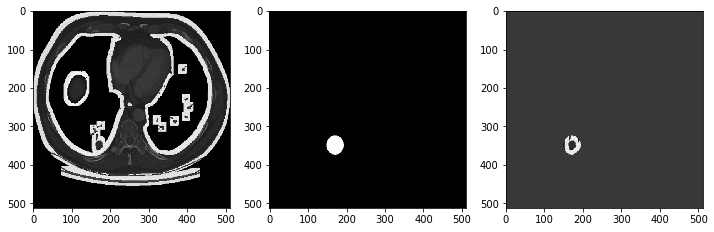

In [33]:
i = 7
print("image %d" % i)
fig,ax = plt.subplots(1,3,figsize=[12,12])
ax[0].imshow(np.squeeze(trainImages[i]),cmap='gray')
ax[1].imshow(np.squeeze(trainMasks[i]),cmap='gray')
ax[2].imshow(np.squeeze(trainImages[i])*np.squeeze(trainMasks[i]),cmap='gray')
plt.show()